# Evaluate deconv GAN

In [2]:
import os
import re
import numpy as np
import pandas as pd
import skimage
import skimage.io
import time

import torch
from torch.utils.data import DataLoader

# 1) Load data

In [3]:
# he NLST
he_nlst_folder = "../data/he/"
he_nlst = [_ for _ in os.listdir(he_nlst_folder) if _.endswith(".png")]

# he MDACC
he_mdacc_folder = "../data/HE_unlabeled/"
he_mdacc = [_ for _ in os.listdir(he_mdacc_folder) if _.endswith(".png")]

# ihc (ori)
ihc_ori = []
for folder in ["CD8", "CD3", "CD68", "PD-L1"]:
    ihc_ori.extend([os.path.join("../data", folder, "ori", _) for _ in os.listdir(os.path.join("../data", folder, "ori"))
                   if _.endswith(".png")])
np.random.seed(1243)
ihc_ori = np.random.choice(ihc_ori, len(he_nlst), replace=False)

# ihc (h channel)
ihc_h_folder = "../data/IHC_H_channel/"
ihc_h = [_ for _ in os.listdir(ihc_h_folder) if _.endswith(".png")]

# Create image dict
he_nlst.sort()
he_mdacc.sort()
ihc_ori.sort()
ihc_h.sort()

image_dict = dict()
slides_he = []
slides_ihc = []
for index in he_nlst:
    _dict = dict()
    _dict['image'] = skimage.io.imread(os.path.join(he_nlst_folder, index))
    _dict['target'] = None
    _dict['image_path'] = os.path.join(he_nlst_folder, index)
    if index[0] == "N":
        _dict['magnitude'] = 20
    else:
        _dict['magnitude'] = 40
    _dict['type'] = "he"
    image_dict[index] = _dict
    slides_he.append(index.split("_")[0])
'''
for index in he_mdacc:
    _dict = dict()
    _dict['image'] = skimage.io.imread(os.path.join(he_mdacc_folder, index))
    _dict['target'] = None
    _dict['image_path'] = os.path.join(he_mdacc_folder, index)
    _dict['magnitude'] = 20
    _dict['type'] = "he"
    image_dict[index] = _dict
    slides_he.append(index.split("_")[0])
'''
for index in ihc_ori:
    _dict = dict()
    _dict['image'] = skimage.io.imread(index)
    _dict['target'] = None
    _dict['image_path'] = index
    _dict['magnitude'] = 20
    _dict['type'] = "ihc"
    image_dict[index] = _dict
    slides_ihc.append(index.split("/")[-1].split("_")[0])
for index in ihc_h:
    _dict = dict()
    _dict['image'] = skimage.io.imread(os.path.join(ihc_h_folder, index))
    _dict['target'] = None
    _dict['image_path'] = os.path.join(ihc_h_folder, index)
    _dict['magnitude'] = 20
    _dict['type'] = "ihc"
    image_dict[index] = _dict
    slides_ihc.append(index.split("_")[0])

slides_he = list(set(slides_he))
slides_ihc = list(set(slides_ihc))
slides_he.sort()
slides_ihc.sort()

# Split train, val, test
he_indexes = []
he_indexes.extend(he_nlst)
'''he_indexes.extend(he_mdacc)'''
np.random.seed(81020)
slides_he_train = np.random.choice(slides_he, int(len(slides_he)*0.85), replace=False)
slides_he_rest = [_ for _ in slides_he if _ not in slides_he_train]
np.random.seed(81020)
slides_he_val = np.random.choice(slides_he_rest, int(len(slides_he_rest)*0.5), replace=False)
slides_he_test = [_ for _ in slides_he_rest if _ not in slides_he_val]
he_indexes_train = [_ for _ in he_indexes if _.split("_")[0] in slides_he_train]
he_indexes_val = [_ for _ in he_indexes if _.split("_")[0] in slides_he_val]
he_indexes_test = [_ for _ in he_indexes if _.split("_")[0] in slides_he_test]
np.random.seed(81020)
slides_ihc_train = np.random.choice(slides_ihc, int(len(slides_ihc)*0.85), replace=False)
slides_ihc_rest = [_ for _ in slides_ihc if _ not in slides_ihc_train]
np.random.seed(81020)
slides_ihc_val = np.random.choice(slides_ihc_rest, int(len(slides_ihc_rest)*0.5), replace=False)
slides_ihc_test = [_ for _ in slides_ihc_rest if _ not in slides_ihc_val]
ihc_ori_indexes_train = [_ for _ in ihc_ori if _.split("/")[-1].split("_")[0] in slides_ihc_train]
ihc_ori_indexes_val = [_ for _ in ihc_ori if _.split("/")[-1].split("_")[0] in slides_ihc_val]
ihc_ori_indexes_test = [_ for _ in ihc_ori if _.split("/")[-1].split("_")[0] in slides_ihc_test]
ihc_h_indexes_train = [_ for _ in ihc_h if _.split("_")[0] in slides_ihc_train]
ihc_h_indexes_val = [_ for _ in ihc_h if _.split("_")[0] in slides_ihc_val]
ihc_h_indexes_test = [_ for _ in ihc_h if _.split("_")[0] in slides_ihc_test]

In [4]:
print(he_indexes_test)

['10878_2_10.png', '10878_2_8.png', '10878_2_9.png', '11460_1_10.png', '11460_1_2.png', '11460_1_3.png', '11460_1_4.png', '11460_1_5.png', '11460_1_6.png', '11460_1_7.png', '11460_1_8.png', '11460_1_9.png', '11460_2_1.png', '11460_2_10.png', '11460_2_2.png', '11460_2_3.png', '11460_2_4.png', '11460_2_5.png', '11460_2_6.png', '11460_2_7.png', '11460_2_8.png', '11460_2_9.png', '9529_1_1.png', '9529_1_2.png', '9529_1_3.png', '9529_1_4.png', 'NLSI0000078_2_10.png', 'NLSI0000078_2_6.png', 'NLSI0000078_2_7.png', 'NLSI0000078_2_8.png', 'NLSI0000078_2_9.png', 'NLSI0000165_1_1.png']


In [5]:
print('# he_indexes_train: {}\n# he_indexes_val: {}\n# he_indexes_test: {}\n'.format(len(he_indexes_train), 
                                                                                     len(he_indexes_val), 
                                                                                     len(he_indexes_test)))
print('# ihc_ori_indexes_train: {}\n# ihc_ori_indexes_val: {}\n# ihc_ori_indexes_test: {}\n'.format(len(ihc_ori_indexes_train), 
                                                                                     len(ihc_ori_indexes_val), 
                                                                                     len(ihc_ori_indexes_test)))
print('# ihc_indexes_train: {}\n# ihc_indexes_val: {}\n# ihc_indexes_test: {}\n'.format(len(ihc_h_indexes_train), 
                                                                                     len(ihc_h_indexes_val), 
                                                                                     len(ihc_h_indexes_test)))

# he_indexes_train: 368
# he_indexes_val: 43
# he_indexes_test: 32

# ihc_ori_indexes_train: 360
# ihc_ori_indexes_val: 43
# ihc_ori_indexes_test: 40

# ihc_indexes_train: 500
# ihc_indexes_val: 40
# ihc_indexes_test: 60



In [6]:
# Define stain_OD_norm
stain_OD = [[0.644211, 0.716556, 0.266844],  # Hematoxylin
            [0.092789, 0.964111, 0.283111],  # Eosin
            [0.268000, 0.570000, 0.776000],  # DAB
            [0.000000, 0.70711, 0.70711],  # Bg-r
            [0.70711, 0.000000, 0.70711],  # Bg-g
            [0.70711, 0.70711, 0.000000],  # Bg-b
           ]
stain_OD_norm = []
for r in stain_OD:
    stain_OD_norm.append(r/np.linalg.norm(r))
stain_OD_norm = torch.tensor(np.asarray(stain_OD_norm))
IMAGE_SHAPE = 512

# 2) Create and check data loader

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
import numpy as np
import math
import skimage
import skimage.transform

import torch
import torch.utils
import torch.utils.data

from utils_image import rgba2rgb, split_masks, Crop, binary_mask_to_polygon
from segmentation_functions import channel_deconvolution

def normalize(image, inverse=False):
    if not inverse:
        image = image/255.
    else:
        image = np.clip(image*255, 0, 255).astype(np.uint8)
    return image

def augmentor(image, label=None, stain=None):
    """Do image shape and color augmentation.
    
    Args:
        image: [h, w, c], float
    """
    n_channels = image.shape[2]
    
    if stain is not None:
        stain = stain/255.
    
    # Shape augmentation
    if np.random.uniform(0, 1) < 0.8:
        # Projective transform
        scale = np.random.uniform(0.9, 1.1)
        aspect_ratio = np.random.uniform(0.9, 1.1)
        rotation = np.random.uniform(-0.1, 0.1)
        translationX = np.random.uniform(-10, 10)
        translationY = np.random.uniform(-10, 10)
        g = np.random.uniform(-0.001, 0.001)
        h = np.random.uniform(-0.001, 0.001)

        matrix = np.array([[math.cos(rotation) * scale * aspect_ratio, -math.sin(rotation), translationX],
                          [math.sin(rotation), math.cos(rotation) * scale / aspect_ratio, translationY],
                          [g, h, 1]])
        tform = skimage.transform.ProjectiveTransform(matrix=matrix)
        image_aug = np.zeros_like(image, dtype=np.float)
        for ch in range(n_channels):
            image_aug[..., ch] = skimage.transform.warp(image[..., ch], tform, preserve_range=True)
        
        image = image_aug
        
        if label is not None:
            label_aug = np.zeros_like(label, dtype=np.int)
            label_aug = skimage.transform.warp(label, tform, preserve_range=True, order=0)
            label = label_aug
            
        if stain is not None:
            stain_aug = np.zeros_like(stain, dtype=np.float)
            for ch in range(n_channels):
                stain_aug[..., ch] = skimage.transform.warp(stain[..., ch], tform, preserve_range=True)
            stain = stain_aug
            
    if np.random.uniform(0, 1) < 0.5:
        # Do 50% vertical flipping
        image = image[::-1, :, :]
        
        if label is not None:
            label = label[::-1, :]
            
        if stain is not None:
            stain = stain[::-1, :]
    if np.random.uniform(0, 1) < 0.5:
        # Do 50% horizontal flipping
        image = image[:, ::-1, :]
        
        if label is not None:
            label = label[:, ::-1]
            
        if stain is not None:
            stain = stain[:, ::-1]

    # Color augmentation
    # 1) add a global shifting for all channels
    image = image + np.random.randn(1)[0] * 0.01

    # 2) add a shifting & variance for each channel
    for ch in range(n_channels):
        image[:, :, ch] = image[:, :, ch] * np.clip(np.random.randn(1)[0] * 0.01 + 1, 0.95, 1.05) + np.random.randn(1)[0] * 0.01
        
    return image, label

class Dataset(torch.utils.data.Dataset):
    __initialized = False
    def __init__(self, indexes_A, indexes_B, image_dict,
                 augmentation=False, crop_size=256, crop_position="random"):
        """
        Args:
            indexes: index used for image_dict
            indexes_A: IHC + HE
            indexes_B: IHC H channel
        """
        self.indexes_A = indexes_A
        self.indexes_B = indexes_B
        self.length_B = len(indexes_B)
        self.image_dict = image_dict
        self.augmentation = augmentation
        self.crop_size = crop_size
        self.crop_position = crop_position
        self.__initialized = True

    def __len__(self):
        """Denotes the number of samples"""
        return len(self.indexes_A)
    
    def __getitem__(self, index):
        """Generate one batch of data.
        
        Returns:
            idx: indexes of samples (long)
        """
        # Generate indexes of the batch
        data_index_A = self.indexes_A[index]
        np.random.seed()
        idx_B = np.random.choice(np.arange(self.length_B))
        data_index_B = self.indexes_B[idx_B]
        
        # Generate data
        image_A, _ = self.__data_generation(data_index_A, index)
        image_B, _ = self.__data_generation(data_index_B, idx_B, h_channel=True)
        
        '''
        data = dict()
        data['A'] = image_A
        data['B'] = image_B
        data['A_paths'] = self.image_dict[data_index_A]['image_path']
        data['B_paths'] = self.image_dict[data_index_B]['image_path']
        data['target_B'] = target_B
        data['stain_A'] = stain_A
        '''

        return image_A, image_B, self.image_dict[data_index_A]['type']
    
    def __data_generation(self, index, idx=0, h_channel=False):
        """Generates image containing batch_size samples.
        
        Args:
            h_channel: if True, return deconvoluted single channel image
        
        Returns:
            image: [b, ch, h, w]
        """
        image = rgba2rgb(self.image_dict[index]['image'])
        target = self.image_dict[index]['target']
        image_path = self.image_dict[index]['image_path']
        
        # Process target
        if target is not None:
            target = normal_cell_to_stroma(rgba2rgb(target))
            objects = split_masks(target, val_to_label=self.val_to_label, dtype='float')
            target = np.transpose(np.array([x['mask'] for x in objects]), (1, 2, 0))
            labels = [x['label'] for x in objects]
        
        # Augmentation
        if h_channel:
            _, image, _, _ = channel_deconvolution(image, "HDB", to_normalize=False)
            image = np.clip(image, 0, None)
            image = image[..., np.newaxis]
        elif self.augmentation:
            image, target = augmentor(image/255., target)
        else:
            image = image/255.
            
        # Resize
        if self.image_dict[index]['magnitude'] == 20:
            image = skimage.transform.rescale(image, 2, preserve_range=True, multichannel=True, order=1)
            if target is not None:
                target = skimage.transform.rescale(target, 2, preserve_range=True, multichannel=True, order=0)
                
        # Random crop
        image, target = Crop(size=(self.crop_size, self.crop_size), pos=self.crop_position)([image, target])
        
        # Filter small objects & create target for MaskRCNN
        if target is not None:
            non_zeros = [(target[..., i], labels[i]) for i in range(len(labels)) if np.sum(target[..., i]) > 10]
            if len(non_zeros):
                target, labels = zip(*non_zeros)
            else:
                target = [np.ones((self.crop_size, self.crop_size))]
                labels = [0]
            target = objects_to_tensor_targets(target, labels, idx)
        
        image = torch.tensor(np.transpose(image, (2, 0, 1)).astype(float))
        
        return image, target
    
    def display(self, indices=None):
        if indices is None:
            indices = range(len(self))
        elif isinstance(indices, int):
            indices = np.random.choice(len(self), indices)
        for i in indices:
            data = self[i]
            image = data['B']
            targets = data['target_B']
            image = image.permute(1, 2, 0).numpy()
            if targets is not None:
                bboxes = targets['boxes'].numpy()
                labels = targets['labels'].numpy()
                masks = targets['masks'].numpy()
            
            fig, ax = plt.subplots(1, 2, figsize=(6 * 2, 6))
            ax[0].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
            ax[1].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
            if targets is not None:
                color = self.label_to_val
                for i, (mask, bbox, label) in enumerate(zip(masks, bboxes, labels)):
                    c = tuple([1.0*_/255 for _ in color[label]]) if label else (0, 0, 0)
                    polygon = binary_mask_to_polygon(mask)
                    for verts in polygon:
                        p = Polygon(np.array(verts[:, ::-1]), facecolor="none", edgecolor=c)
                        ax[1].add_patch(p)
                    y1, x1, y2, x2 = bbox
                    b = Rectangle((y1, x1), (y2-y1), (x2-x1), linewidth=2,
                                  alpha=0.5, linestyle="solid", edgecolor=c, facecolor="none")
                    ax[1].add_patch(b)

            plt.show()
            
# def collate_fn(batch):
#     return list(batch)

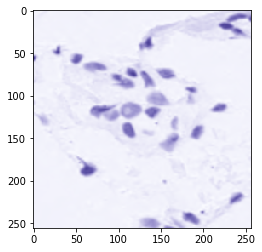

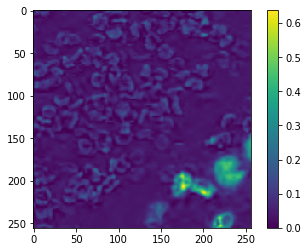

('ihc', 'he')


In [129]:
# Generator
train_set = Dataset(he_indexes_train+ihc_h_indexes_train, ihc_ori_indexes_train, image_dict, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True, num_workers=1, 
                                          )  # collate_fn=collate_fn)
for image, real_h, stain_type in train_loader:
    plt.imshow(normalize(np.transpose(image[0].numpy(), (1, 2, 0)), inverse=True))
    plt.show()
    plt.imshow(real_h[0].numpy()[0])
    plt.colorbar()
    plt.show()
    print(stain_type)
    break

# 3) Create model

In [9]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

######## Activations ########

class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)
    
######## Blocks ########
    
class ResidualBlock(nn.Module):
    def __init__(self, channels, activation=nn.PReLU()):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.activation = activation
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.activation(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return self.activation(x + residual)
    
######## Encoder ########
    
class ODEncoder(nn.Module):
    def __init__(self, activation=nn.PReLU()):
        '''
        Args:
            activation: nn.PReLU(), nn.ReLU(), nn.LeakyReLU(0.2), Mish()
        '''
        super(ODEncoder, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            activation
        )
        self.block2 = ResidualBlock(64, activation)
        self.block3 = ResidualBlock(64, activation)
        self.block4 = ResidualBlock(64, activation)
        self.block5 = ResidualBlock(64, activation)
        self.block6 = ResidualBlock(64, activation)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 6, kernel_size=3, padding=1),
            nn.BatchNorm2d(6)
        )
        
        self.block8 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            activation,
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            activation,
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            activation,
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            activation,
            nn.AdaptiveMaxPool2d((1, 1))
        )
        self.block9 = nn.Sequential(
            nn.Linear(32, 3*3),
            activation
        )
        self.block10 = nn.Sequential(
            nn.Linear(32, 2), 
            activation
        )

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block1 + block6)
        
        block8 = self.block8(block1)
        block8 = block8.view(-1, 32)
        block9 = self.block9(block8)
        block9 = block9.view(-1, 3, 3)
        block9 = torch.sqrt(F.softmax(block9, -1))
        block10 = self.block10(block8)

        return nn.ReLU()(block7), block9, block10
    
def reconstruct(ODs, stain_OD_norm, device):
    '''Reconstruct image from different stains
    
    Args:
        ODs: [B, n_stains, H, W]
        stain_OD_norm: [n_stains, 3 (R, G, B)] or [B, n_stains, 3 (R, G, B)]
    '''
    if not isinstance(ODs, torch.Tensor):
        ODs = torch.tensor(ODs).float()
    if not isinstance(stain_OD_norm, torch.Tensor):
        stain_OD_norm = torch.tensor(stain_OD_norm)
    if len(ODs.size()) != 4:
        raise Exception("ODs should be of shape [B, n_stains, H, W]")
    if len(stain_OD_norm.size()) == 2:
        # If the batch of images have the same stain_OD_norm
        ODs = ODs.permute(0, 2, 3, 1)
        ODs = ODs.to(device)
        stain_OD_norm = stain_OD_norm.to(device)
        stain_OD_norm = stain_OD_norm.float()
        reconstructed = torch.matmul(ODs, stain_OD_norm)
        reconstructed = torch.exp(torch.neg(reconstructed.permute(0, 3, 1, 2)))
    elif len(stain_OD_norm.size()) == 3:
        # If the batch of images have different stain_OD_norms
        size = ODs.size()
        ODs = ODs.view(size[0], size[1], size[2] * size[3])
        ODs = ODs.permute(0, 2, 1)
        ODs = ODs.to(device)
        stain_OD_norm = stain_OD_norm.to(device)
        stain_OD_norm = stain_OD_norm.float()
        reconstructed = torch.bmm(ODs, stain_OD_norm)  #[B, H*W, 3]
        reconstructed = torch.exp(torch.neg(reconstructed.permute(0, 2, 1)))
        reconstructed = reconstructed.view(size[0], 3, size[2], size[3])
    return reconstructed

In [10]:
# Losses
import torch
from torch import nn
from torchvision.models.vgg import vgg16
from torchvision.transforms import Normalize

class ReconstructionLoss(nn.Module):
    def __init__(self, weight=None):
        super(ReconstructionLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        if weight is None:
            self.weight_image_loss = 10
            self.weight_perceptual_loss = 1
            self.weight_bg_penalty = 0.1
            self.weight_stain_penalty = 0.1
            self.weight_h_sparsity = 0.1
            self.weight_e_penalty = 0.1
            self.weight_cov_penalty = 1
        else:
            self.weight_image_loss = weight[0]
            self.weight_perceptual_loss = weight[1]
            self.weight_bg_penalty = weight[2]
            self.weight_stain_penalty = weight[3]
            self.weight_h_sparsity = weight[4]
            if len(weight) > 5:
                self.weight_e_penalty = weight[5]
            else:
                self.weight_e_penalty = 0
            if len(weight) > 6:
                self.weight_cov_penalty = weight[6]
            else:
                self.weight_cov_penalty = 0
        
    def forward(self, recon_images_exact, recon_images_valid, target_images, ODs, stain_types):
        '''
        Args:
            recon_images: in shape [b, c, h, w]. exact: use all channels; valid: use valid channels
        '''
        # Image Loss
        image_loss = self.mse_loss(recon_images_exact, target_images)
        
        # Perceptual Loss
        recon_images_n = recon_images_valid.clone()
        target_images_n = target_images.clone()
        for ch in range(3):
            recon_images_n[:, ch, ...] = (recon_images_valid[:, ch, ...] - self.mean[ch])/self.std[ch]
            target_images_n[:, ch, ...] = (target_images[:, ch, ...] - self.mean[ch])/self.std[ch]
        perceptual_loss = self.mse_loss(self.loss_network(recon_images_n), 
                                        self.loss_network(target_images_n))
        # Background penalty
        for i, stain_type in enumerate(stain_types):
            if i != 0:
                if stain_type == "he":
                    bg_penalty += torch.mean(ODs[i, [2, 3, 4, 5], ...])
                elif stain_type == "ihc":
                    bg_penalty += torch.mean(ODs[i, [1, 3, 4, 5], ...])
            else:
                if stain_type == "he":
                    bg_penalty = torch.mean(ODs[i, [2, 3, 4, 5], ...])
                elif stain_type == "ihc":
                    bg_penalty = torch.mean(ODs[i, [1, 3, 4, 5], ...])
        bg_penalty = torch.div(bg_penalty, i + 1)
                    
        # Stain penalty
        for i, stain_type in enumerate(stain_types):
            if i != 0:
                if stain_type == "he":
                    stain_penalty += torch.mean(ODs[i, [0, 1], ...])
                elif stain_type == "ihc":
                    stain_penalty += torch.mean(ODs[i, [0, 2], ...])
            else:
                if stain_type == "he":
                    stain_penalty = torch.mean(ODs[i, [0, 1], ...])
                elif stain_type == "ihc":
                    stain_penalty = torch.mean(ODs[i, [0, 2], ...])
        stain_penalty = torch.div(stain_penalty, i + 1)
        
        # H sparsity
        h_sparsity = torch.sum(ODs[:, 0, ...]).float()/ODs.size()[0]/ODs.size()[2]/ODs.size()[3]
        
        # E penalty
        j = 0
        for i, stain_type in enumerate(stain_types):
            if j != 0:
                if stain_type == "he":
                    e_penalty += torch.mean(ODs[i, [1], ...])
            else:
                if stain_type == "he":
                    e_penalty = torch.mean(ODs[i, [1], ...])
                    j += 1
        e_penalty = torch.div(e_penalty, i + 1)
        
        # Covariance penalty
        cov_penalty = torch.mean(ODs[:, 0, ...] * ODs[:, 1, ...]) - torch.mean(ODs[:, 0, ...]) * torch.mean(ODs[:, 1, ...])
        
        self.image_loss = self.weight_image_loss * image_loss
        self.perceptual_loss = self.weight_perceptual_loss * perceptual_loss
        self.bg_penalty = self.weight_bg_penalty * bg_penalty
        self.stain_penalty = self.weight_stain_penalty * stain_penalty
        self.h_sparsity = self.weight_h_sparsity * h_sparsity
        self.e_penalty = self.weight_e_penalty * e_penalty
        self.cov_penalty = self.weight_cov_penalty * cov_penalty
        
        return self.image_loss + self.perceptual_loss + self.bg_penalty + self.stain_penalty + self.h_sparsity + self.e_penalty \
                 + self.cov_penalty

In [11]:
import torch

# self-defined functions
from util.image_pool import ImagePool
import networks

class DeconvGAN():
    def __init__(self, is_train=True, device="0", activation=Mish(), weight=[10, 1, 0.1, 0, 0, 0, 0], 
                lr=0.0002, beta1=0.5, save_dir="./models/", n_epochs=500, n_epochs_decay=100):
        self.is_train = is_train
        self.device = device
        self.save_dir = save_dir  # which folder to save models
        self.n_epochs = n_epochs
        self.n_epochs_decay = n_epochs_decay
        
        if self.is_train:
            self.model_names = ['G', 'D']
        else:
            self.model_names = ['G']

        # define networks 
        self.netG = ODEncoder(activation=activation)
        self.netG = self.netG.to(self.device)

        if self.is_train:  # define discriminators
            '''    Parameters:
            input_nc (int)     -- the number of channels in input images
            ndf (int)          -- the number of filters in the first conv layer
            netD (str)         -- the architecture's name: basic | n_layers | pixel
            n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
            norm (str)         -- the type of normalization layers used in the network.
            init_type (str)    -- the name of the initialization method.
            init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
            gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2'''
            self.netD = networks.define_D(input_nc=1, ndf=64, netD="basic", n_layers_D=3,
                                          norm="instance", init_type="normal", init_gain=0.02, gpu_ids=[device])
            
        self.criterionRec = ReconstructionLoss(weight=weight).to(self.device)
        
        if self.is_train:
            self.fake_pool = ImagePool(50)
            # define loss functions
            self.criterionGAN = networks.GANLoss("lsgan").to(self.device)  # define GAN loss.
            # initialize optimizers
            self.optimizers = []
            self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=lr, betas=(beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=lr, betas=(beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)
            self.schedulers = [networks.get_scheduler(optimizer, lr_policy="linear", 
                                                      n_epochs=n_epochs, n_epochs_decay=n_epochs_decay) for optimizer in self.optimizers]

    def set_input(self, data):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.
        Parameters:
            input (dict): include the data itself and its metadata information.
        """
        self.images = data[0].float().to(self.device)
        self.real_hs = data[1].float().to(self.device)
        self.stain_types = data[2]

    def forward(self, val=False):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        if val:
            self.netG.eval()
        else:
            self.netG.train()
        self.ODs, self.stain_OD_norm_preds, self.params_lt = self.netG(self.images)
        self.fake_hs = torch.log(self.ODs[:, 0:1, ...] + 1) * self.params_lt[:, 0, None, None, None] + \
                                 self.params_lt[:, 1, None, None, None]
        
        # Add rgb to ODs
        rgb_ODs = torch.stack([torch.tensor([[0, 0.70711, 0.70711], 
                                             [0.70711, 0, 0.70711], 
                                             [0.70711, 0.70711, 0]]) for _ in range(self.ODs.size()[0])], 0)
        self.stain_OD_norm_preds = torch.cat([self.stain_OD_norm_preds, rgb_ODs.to(self.device)], 1)
        
        self.recon_images_exact = reconstruct(self.ODs, self.stain_OD_norm_preds, self.device)
        self.recon_images_valid = torch.zeros_like(self.recon_images_exact).to(self.device)
        for i, stain_type in enumerate(self.stain_types):
            if stain_type == "he":
                self.recon_images_valid[i:i+1, ...] = reconstruct(self.ODs[i:i+1, 0:2, ...], 
                                                             self.stain_OD_norm_preds[i:i+1, 0:2, ...], self.device)
            if stain_type == "ihc":
                self.recon_images_valid[i:i+1, ...] = reconstruct(self.ODs[i:i+1, [0, 2], ...], 
                                                             self.stain_OD_norm_preds[i:i+1, [0, 2], ...], self.device)
        self.loss_rec = self.criterionRec(self.recon_images_exact, self.recon_images_valid, self.images, self.ODs, self.stain_types)
        self.image_loss = self.criterionRec.image_loss
        self.perceptual_loss = self.criterionRec.perceptual_loss
        self.bg_penalty = self.criterionRec.bg_penalty
        self.stain_penalty = self.criterionRec.stain_penalty
        self.h_sparsity = self.criterionRec.h_sparsity
        self.e_penalty = self.criterionRec.e_penalty
        self.cov_penalty = self.criterionRec.cov_penalty

    def backward_D_basic(self, netD, real, fake, val=False):
        """Calculate GAN loss for the discriminator
        Parameters:
            netD (network)      -- the discriminator D
            real (tensor array) -- real images
            fake (tensor array) -- images generated by a generator
        Return the discriminator loss.
        We also call loss_D.backward() to calculate the gradients.
        """
        # Real
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        if not val:
            loss_D.backward()
        return loss_D

    def backward_D(self, val=False):
        """Calculate GAN loss for discriminator D_A"""
        fake_hs = self.fake_pool.query(self.fake_hs)
        self.loss_D = self.backward_D_basic(self.netD, self.real_hs, fake_hs, val=val)

    def backward_G(self, val=False):
        """Calculate the loss for generator G"""

        # GAN loss
        self.loss_gan = self.criterionGAN(self.netD(self.fake_hs), True)
        # combined loss and calculate gradients
        self.loss_G = self.loss_gan + self.loss_rec
        
        if not val:
            self.loss_G.backward()
            
    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()      # compute fake images and reconstruction images.
        # G
        self.set_requires_grad([self.netD], False)  # Ds require no gradients when optimizing Gs
        self.optimizer_G.zero_grad()  # set G_A and G_B's gradients to zero
        self.backward_G()             # calculate gradients for G_A and G_B
        self.optimizer_G.step()       # update G_A and G_B's weights
        # D
        self.set_requires_grad([self.netD], True)
        self.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero
        self.backward_D()      # calculate gradients for D_A
        self.optimizer_D.step()  # update D_A and D_B's weights
        
    def forward_wo_optimize_parameters(self):
        """Calculate losses in validation set, run within torch.no_grad()"""
        # forward
        self.forward(val=True)
        self.backward_G(val=True)
        self.backward_D(val=True) 
        
    def save_networks(self, epoch):
        """Save all the networks to the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if isinstance(net, torch.nn.DataParallel):
                    torch.save(net.module.state_dict(), save_path)
                else:
                    torch.save(net.state_dict(), save_path)

    def load_networks(self, epoch):
        """Load all the networks from the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                # for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                #     self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)
                
    def update_learning_rate(self):
        """Update learning rates for all the networks; called at the end of every epoch"""
        old_lr = self.optimizers[0].param_groups[0]['lr']
        for scheduler in self.schedulers:
            scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate %.7f -> %.7f' % (old_lr, lr))

In [12]:
# Create model dir
model_dir = "./models/deconv-GAN-512-40X-9"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model = DeconvGAN(is_train=False, device=torch.device("cuda:0"), save_dir=model_dir, weight=[200, 1, 10, 0, 0.1, 0.2, 0.2])

# Load model
model.load_networks(599)  #

loading the model from ./models/deconv-GAN-512-40X-9/599_net_G.pth


# 4) Evaluate

In [13]:
def get_stain_OD_norm_gt(df, image_name, bg=(0.754000, 0.077000, 0.652000)):
    OD_h = df.loc[df['image name'] == image_name, ("hR", "hG", "hB")].values
    OD_e = df.loc[df['image name'] == image_name, ("eR", "eG", "eB")].values
    OD_h = -np.log(OD_h / 255 + 0.0001)
    OD_h = (OD_h.T/np.linalg.norm(OD_h, axis=1).T).T
    OD_h = np.mean(OD_h, axis=0)
    OD_h /= np.linalg.norm(OD_h)
    OD_e = -np.log(OD_e / 255 + 0.0001)
    OD_e = (OD_e.T/np.linalg.norm(OD_e, axis=1).T).T
    OD_e = np.mean(OD_e, axis=0)
    OD_e /= np.linalg.norm(OD_e)
    OD_norm = np.asarray((OD_h, OD_e, bg))
    return torch.tensor(OD_norm)

def preprocess(image, image_size):
    if image.size()[2] < image_size:
        image_temp = torch.zeros(image.size()[0], image.size()[1], image_size, image_size)
        start = int((image_size - image.size()[2])/2)
        image_temp[:, :, start:start + image.size()[2], start:start + image.size()[2]] = image
        image = image_temp.contiguous()
    return image

def postprocess(image, origin_size):
    if image.size()[2] > origin_size:
        start = -int((origin_size - image.size()[2])/2)
        image_temp = image[:, :, start:start + origin_size, start:start + origin_size]
        image = image_temp.contiguous()
    return image

In [14]:
# Define stain_OD_norm for HE deconv
stain_OD_deconv = [[0.644211, 0.716556, 0.266844],  # Hematoxylin
                   [0.092789, 0.964111, 0.283111],  # Eosin
                   [0.754000, 0.077000, 0.652000]  # Bg
                  ]
stain_OD_norm_deconv = []
for r in stain_OD_deconv:
    stain_OD_norm_deconv.append(r/np.linalg.norm(r))
stain_OD_norm_deconv = torch.tensor(np.asarray(stain_OD_norm_deconv))

In [15]:
test_set = Dataset(he_indexes_test, ihc_h_indexes_test, image_dict, augmentation=False, crop_size=IMAGE_SHAPE, 
                  crop_position="center")
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=10)

stain_OD_gt_df = pd.read_csv("../data/he_color_sampler_eosin.csv")
stain_OD_gt_df

,image name,hR,hG,hB,eR,eG,eB
0,10878_2_10.png,31,11,41,110,42,75
1,10878_2_10.png,31,14,19,137,54,91
2,10878_2_10.png,22,10,38,189,113,143
3,10878_2_10.png,30,8,35,225,116,143
4,10878_2_10.png,17,12,42,220,124,163
5,10878_2_8.png,72,33,89,249,131,170
6,10878_2_8.png,83,29,80,251,112,141
7,10878_2_8.png,34,20,59,219,137,158
8,10878_2_8.png,65,27,75,168,61,112
9,10878_2_8.png,78,36,99,226,115,150


In [ ]:
model.netG.eval()
device = model.device

pred_OD_matrixs = []
gt_OD_matrixs = []
pred_ODs = []
gt_ODs = []


for idx, (images, _, _) in enumerate(test_loader):
    # if idx % 5 != 0:
    #     continue
    print(idx)
    image_name = he_indexes_test[idx]
    batch_size = images.size(0)
    origin_size = images.size(2)
    images_norm = preprocess(images, IMAGE_SHAPE).float().to(device)
    
    # =================== forward =====================
    with torch.no_grad():
        ODs, stain_OD_norm_pred, params_lt = model.netG(images_norm)
        ODs = postprocess(ODs.cpu(), origin_size).to(device)
        # Linear transformation
        # ODs[:, 0:1, ...] = ODs[:, 0:1, ...] * params_lt[:, 0, None, None, None] + params_lt[:, 1, None, None, None]
        # Add rgb to ODs
        rgb_ODs = torch.stack([torch.tensor([[0, 0.70711, 0.70711], 
                                             [0.70711, 0, 0.70711], 
                                             [0.70711, 0.70711, 0]]) for _ in range(ODs.size()[0])], 0)
        stain_OD_norm_pred = torch.cat([stain_OD_norm_pred, rgb_ODs.to(device)], 1)
    print(stain_OD_norm_pred)
    print(params_lt)
    recon_images = reconstruct(ODs[:, 0:2, ...], stain_OD_norm_pred[:, 0:2, ...], device)
    recon_images_h = reconstruct(ODs[:, 0:1, ...], stain_OD_norm_pred[:, 0:1, ...], device)
    recon_images_e = reconstruct(ODs[:, 1:2, ...], stain_OD_norm_pred[:, 1:2, ...], device)
    recon_images_b = reconstruct(ODs[:, 2:6, ...], stain_OD_norm_pred[:, 2:6, ...], device)

    ori_image = np.transpose(np.array(images.detach().cpu().numpy()*255, dtype=np.uint8), (0, 2, 3, 1))[0]
    # _, ch1, ch2, ch3 = channel_deconvolution(ori_image, "HEB", to_normalize=False)
    stain_OD_norm_deconv = get_stain_OD_norm_gt(stain_OD_gt_df, image_name, bg=(0.754000, 0.077000, 0.652000))
    print(stain_OD_norm_deconv)
    _, ch1, ch2, ch3 = channel_deconvolution(ori_image, "costom", to_normalize=False, 
                                             channels=("H", "E", "B"), 
                                             stain_OD=stain_OD_norm_deconv.numpy())
    _temp = np.array([[ch1, ch2, ch3]])
    recon_images_deconv = reconstruct(_temp[:, 0:2, ...], stain_OD_norm_deconv[0:2], device)
    recon_images_deconv_h = reconstruct(_temp[:, 0:1, ...], stain_OD_norm_deconv[0:1], device)
    recon_images_deconv_e = reconstruct(_temp[:, 1:2, ...], stain_OD_norm_deconv[1:2], device)
    recon_images_deconv_b = reconstruct(_temp[:, 2:3, ...], stain_OD_norm_deconv[2:3], device)
    
    # Save res
    pred_OD_matrixs.append(stain_OD_norm_pred)
    gt_OD_matrixs.append(stain_OD_norm_deconv)
    pred_ODs.append(ODs)
    gt_ODs.append(_temp)
    
    plt.figure(figsize=(20, 5))
    plt.subplot(141)
    plt.imshow(np.transpose(np.array(images.cpu().numpy()*255, dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Original Image")
    plt.subplot(142)
    plt.imshow(np.transpose(np.array(reconstruct(ODs, stain_OD_norm_pred, device).detach().cpu().numpy()*255, 
                                     dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Reconstructed Image (All)")
    plt.subplot(143)
    plt.imshow(np.transpose(np.array(reconstruct(ODs, stain_OD_norm, device).detach().cpu().numpy()*255, 
                                     dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Normalized Image")
    plt.subplot(144)
    plt.imshow(np.transpose(np.array(np.clip(reconstruct(torch.log(ODs[:, 0:1, ...] + 1) * params_lt[:, 0, None, None, None] + \
                                                           params_lt[:, 1, None, None, None], 
                                                [[0.644211, 0.716556, 0.266844]], device).detach().cpu().numpy()*255, 0, 255),
                                                 # stain_OD_norm_deconv[0:1], device).detach().cpu().numpy()*255, 0, 255), 
                                     dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Fake IHC H channel")
    plt.show()
    
    plt.figure(figsize=(20, 5))
    plt.subplot(141)
    plt.imshow(np.transpose(np.array(recon_images.detach().cpu().numpy()*255, dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Reconstructed")
    plt.subplot(142)
    plt.imshow(np.transpose(np.array(recon_images_h.detach().cpu().numpy()*255, dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Hematoxylin")
    plt.subplot(143)
    plt.imshow(np.transpose(np.array(recon_images_e.detach().cpu().numpy()*255, dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Eosin")
    plt.subplot(144)
    plt.imshow(np.transpose(np.array(recon_images_b.detach().cpu().numpy()*255, dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Background")
    plt.show()
    
    plt.figure(figsize=(20, 5))
    plt.subplot(141)
    plt.imshow(np.transpose(np.array(np.clip(recon_images_deconv.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Reconstructed")
    plt.subplot(142)
    plt.imshow(np.transpose(np.array(np.clip(recon_images_deconv_h.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Hematoxylin")
    plt.subplot(143)
    plt.imshow(np.transpose(np.array(np.clip(recon_images_deconv_e.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Eosin")
    plt.subplot(144)
    plt.imshow(np.transpose(np.array(np.clip(recon_images_deconv_b.detach().cpu().numpy()*255, 0, 255), dtype=np.uint8), (0, 2, 3, 1))[0])
    plt.title("Background")
    plt.show()

## 4.1) Evaluate OD matrixs

In [17]:
diff_h = []
diff_e = []
diff_all = []
for pred_OD_matrix, gt_OD_matrix in zip(pred_OD_matrixs, gt_OD_matrixs):
    pred_OD_matrix = pred_OD_matrix[0, 0:3, :].cpu().numpy()
    gt_OD_matrix = gt_OD_matrix.cpu().numpy()
    diff_h.append(np.sqrt(np.sum((pred_OD_matrix[0] - gt_OD_matrix[0]) ** 2)))
    diff_e.append(np.sqrt(np.sum((pred_OD_matrix[1] - gt_OD_matrix[1]) ** 2)))
    diff_all.append((np.sqrt(np.sum((pred_OD_matrix[0] - gt_OD_matrix[0]) ** 2)) + \
                     np.sqrt(np.sum((pred_OD_matrix[1] - gt_OD_matrix[1]) ** 2)))/2)
print("Diff from gt_H: ", np.average(diff_h))
print("Diff from gt_E: ", np.average(diff_e))
print("Average diff: ", np.average(diff_all))

Diff from gt_H:  0.0932950185022243
Diff from gt_E:  0.08389769790304183
Average diff:  0.08859635820263306


In [18]:
print("SE from gt_H: ", np.std(diff_h, ddof=1))
print("SE from gt_E: ", np.std(diff_e, ddof=1))
print("SE from gt_ave: ", np.std(diff_all, ddof=1))

SE from gt_H:  0.03339800604302196
SE from gt_E:  0.0485568776922818
SE from gt_ave:  0.03678468507075416


## 4.2) Evaluate nuclei signal-gt correlation

In [46]:
# Create and save gt mask
'''
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes
from scipy import misc
for i in range(len(gt_ODs)):
    image_name = he_indexes_test[i]
    OD_h = gt_ODs[i][0, 0, ...]
    OD_h = OD_h > threshold_otsu(OD_h)
    OD_h = remove_small_objects(OD_h, 100)
    OD_h = remove_small_holes(OD_h, 20)
    OD_h_c = np.zeros((OD_h.shape[0], OD_h.shape[1], 4), dtype=np.uint8)
    OD_h_c[..., 1] = OD_h * 255
    OD_h_c[..., 3] = OD_h * 255
    misc.imsave(os.path.join("../data/he_test_nuclei_mask/", image_name), OD_h_c)
'''

/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [74]:
i = 22
image_name = he_indexes_test[i]
nuclei_gt = skimage.io.imread(os.path.join("../data/he_test_nuclei_mask/", image_name))[..., 1] > 200
OD_h = pred_ODs[i].cpu().numpy()[0, 0, ...]

from sklearn.metrics import roc_auc_score
print(roc_auc_score(nuclei_gt, OD_h))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(nuclei_gt.astype(int).reshape(-1), OD_h.reshape(-1))

OD_h = np.array(OD_h > threshold_otsu(OD_h), dtype=int)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(OD_h.reshape(-1), nuclei_gt.reshape(-1))
print(cm[1, 1]/(np.sum(cm) - cm[0, 0]))

0.8879350291368918
0.37191762085271013


In [146]:
from sklearn.metrics import roc_auc_score, roc_curve

auc_scores = []
fprs = []
tprs = []
nuclei_gts = []
OD_hs = []

for i in range(len(he_indexes_test)):
    image_name = he_indexes_test[i]
    nuclei_gt = rgba2rgb(skimage.io.imread(os.path.join("../data/he_test_nuclei_mask/", image_name)))[..., 1] == 255
    nuclei_gt = nuclei_gt.astype(int).reshape(-1)
    OD_h = pred_ODs[i].cpu().numpy()[0, 0, ...].reshape(-1)
    
    fpr, tpr, thresholds = roc_curve(nuclei_gt, OD_h)
    fprs.append(fpr)
    tprs.append(tpr)
    auc_scores.append(roc_auc_score(nuclei_gt, OD_h))
    nuclei_gts.append(nuclei_gt)
    OD_hs.append(OD_h)

0.9775468682945145
0.013891569035615246
0.9644344602205737


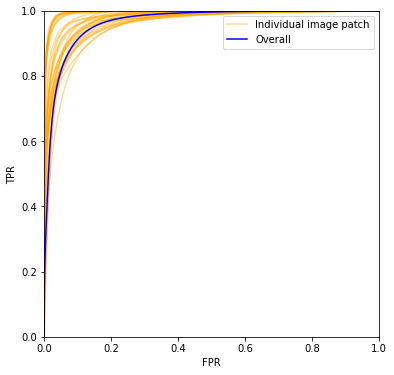

In [147]:
print(np.average(auc_scores))
print(np.std(auc_scores, ddof=1))
print(roc_auc_score(np.concatenate(nuclei_gts).reshape(-1), np.concatenate(OD_hs).reshape(-1)))

# Plot
plt.figure(figsize=(6, 6))
for i in range(len(he_indexes_test)):
    if i == 0:
        plt.plot(fprs[i], tprs[i], color='orange', alpha=0.4, label='Individual image patch')
    else:
        plt.plot(fprs[i], tprs[i], color='orange', alpha=0.4)
fpr, tpr, thresholds = roc_curve(np.concatenate(nuclei_gts).reshape(-1), np.concatenate(OD_hs).reshape(-1))
plt.plot(fpr, tpr, color='blue', label='Overall')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

torch.save([fpr, tpr], "../outputs/2_roc_curve_evaluate_deconv_GAN_512_40X_9.pt")

## Manual OD

0.9563889315667233
0.0332210058567219
0.9485071753428138


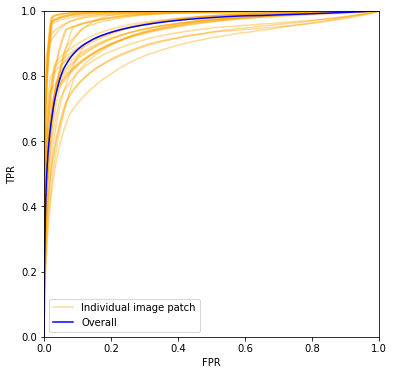

In [149]:
from sklearn.metrics import roc_auc_score, roc_curve

auc_scores = []
fprs = []
tprs = []
nuclei_gts = []
OD_h_gts = []

for i in range(len(he_indexes_test)):
    image_name = he_indexes_test[i]
    nuclei_gt = rgba2rgb(skimage.io.imread(os.path.join("../data/he_test_nuclei_mask/", image_name)))[..., 1] ==255
    nuclei_gt = nuclei_gt.astype(int).reshape(-1)
    OD_h = gt_ODs[i][0, 0, ...].reshape(-1)
    
    fpr, tpr, thresholds = roc_curve(nuclei_gt, OD_h)
    fprs.append(fpr)
    tprs.append(tpr)
    auc_scores.append(roc_auc_score(nuclei_gt, OD_h))
    nuclei_gts.append(nuclei_gt)
    OD_h_gts.append(OD_h)
    
print(np.average(auc_scores))
print(np.std(auc_scores, ddof=1))
print(roc_auc_score(np.concatenate(nuclei_gts).reshape(-1), np.concatenate(OD_h_gts).reshape(-1)))

# Plot
plt.figure(figsize=(6, 6))
for i in range(len(he_indexes_test)):
    if i == 0:
        plt.plot(fprs[i], tprs[i], color='orange', alpha=0.4, label='Individual image patch')
    else:
        plt.plot(fprs[i], tprs[i], color='orange', alpha=0.4)
fpr, tpr, thresholds = roc_curve(np.concatenate(nuclei_gts).reshape(-1), np.concatenate(OD_h_gts).reshape(-1))
plt.plot(fpr, tpr, color='blue', label='Overall')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

torch.save([fpr, tpr], "../outputs/2_roc_curve_evaluate_gt.pt")

# Session Info

In [1]:
!pip freeze

absl-py==0.7.0
altair==3.2.0
argh==0.26.2
astor==0.7.1
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.1.0
autograd==1.2
backcall==0.1.0
base58==1.0.3
bleach==1.5.0
blinker==1.4
boto3==1.10.15
botocore==1.13.15
Bottleneck==1.2.1
cachetools==4.1.0
certifi==2019.3.9
chardet==3.0.4
Click==7.0
cvxopt==1.2.3
cvxpy==1.0.24
cycler==0.10.0
Cython==0.29.15
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
docutils==0.15.2
ecos==2.0.7.post1
entrypoints==0.3
enum-compat==0.0.3
environment-kernels==1.1.1
FITS-tools==0.2
future==0.17.1
gast==0.2.2
google-auth==1.14.3
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
grpcio==1.29.0
h5py==2.10.0
html5lib==0.9999999
idna==2.8
image-registration==0.2.4
imageio==2.6.1
importlib-metadata==0.23
ipykernel==5.1.0
ipython==7.4.0
ipython-genutils==0.2.0
ipywidgets==7.4.2
isodate==0.6.0
jedi==0.13.3
Jinja2==2.10.1
jmespath==0.9.4
jsonschema==3.0.1
jupyter==1.0.0
jupyter-client==5.2.4
jupyter-console==6.0.0
jupyter-core==4.4.0
Keras==2.3.1
Keras-Applications==1.0.8
Ker